In [71]:
import pypsa
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import math
from shapely import wkt

pd.set_option("display.max_columns", 1000)

In [ ]:
# links
# https://drive.google.com/drive/folders/18dV790r11hHKIwpbyDBaxMV4XbhBFQde?usp=drive_link

In [77]:
# networks
de_base_nc_file = "osm_data_validation_AT_MK_IT_DE/networks/DE/base.nc"
it_base_nc_file = "osm_data_validation_AT_MK_IT_DE/networks/IT/base.nc"

# resources
de_base_csv_file = "osm_data_validation_AT_MK_IT_DE/resources/DE/base_network/all_lines_build_network.csv"
it_base_csv_file = "osm_data_validation_AT_MK_IT_DE/resources/IT/base_network/all_lines_build_network.csv"

de_country_shape_file = "osm_data_validation_AT_MK_IT_DE/resources/DE/shapes/country_shapes.geojson"
it_country_shape_file = "osm_data_validation_AT_MK_IT_DE/resources/IT/shapes/country_shapes.geojson"

In [102]:
de_base_nc = pypsa.Network(de_base_nc_file)
it_base_nc = pypsa.Network(it_base_nc_file)

de_base_network = pd.read_csv(de_base_csv_file)
it_base_network = pd.read_csv(it_base_csv_file)

INFO:pypsa.io:Imported network base.nc has buses, lines, links, transformers
INFO:pypsa.io:Imported network base.nc has buses, lines, links, transformers


In [78]:
de_country_shape = gpd.read_file(de_country_shape_file)
it_country_shape = gpd.read_file(it_country_shape_file)

In [79]:
# load entsoe line.csv with pandas dataframe
entsoe_ref_csv = pd.read_csv("entsoe_lines_ref.csv", delimiter=",", quotechar="'")

# apply well known text(wkt) to format the geometry column properly
entsoe_ref_csv["geometry"] = entsoe_ref_csv.geometry.apply(wkt.loads)

# load the data into a geopandas dataframe and format it using a compatible crs
entsoe = gpd.GeoDataFrame(entsoe_ref_csv, geometry="geometry", crs="EPSG:3035")

# convert voltage from kV to V
entsoe["voltage"] = entsoe.voltage * 1000

In [223]:
def if_country_in_entsoe(country_df: gpd.GeoDataFrame, base_data: gpd.GeoDataFrame) -> pd.Series:
    """
    Function checks if country_df is present in enstoe data
    """
    x = base_data["geometry"].apply(lambda row: row.within(country_df["geometry"][0]))
    return x

def get_i_nom_by_voltage(voltage_value: int) -> int:

    voltage_dict = {
        "220" : 1.29, # "Al/St 240/40 2-bundle 220.0"
        "300" : 1.935, # "Al/St 240/40 3-bundle 300.0,"
        "380" : 2.58 # "Al/St 240/40 4-bundle 380.0"
    }

    if voltage_value <= 220000:
        current = voltage_dict["220"]
    elif voltage_value > 220000 and voltage_value <= 300000:
        current = voltage_dict["300"]
    elif voltage_value > 300000:
        current = voltage_dict["380"]

    return current #units in kA

def calculate_s_nom(df: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    # s_nom = sqrt(3) * v_nom(V) * i_nom(kA)
    # divide voltage by 1000 to convert it to kV
   
    df["s_nom"] = df["voltage"].apply(lambda row: (row / 1000) * math.sqrt(3) * get_i_nom_by_voltage(row))
    df["s_nom"] = df["s_nom"] / 1000  # s_nom units in MVA

    return df
    

In [224]:
de_base_network_s_nom = calculate_s_nom(de_base_network)
it_base_network_s_nom = calculate_s_nom(it_base_network)

In [225]:
entsoe["if_de"] = if_country_in_entsoe(de_country_shape, entsoe)
entsoe["if_it"] = if_country_in_entsoe(it_country_shape, entsoe)

In [227]:
de_nc_s_nom_sum = (de_base_nc.lines.s_nom * de_base_nc.lines.length).sum()
de_nc_s_nom_sum

153343515.04116735

In [229]:
de_base_s_nom_sum = (de_base_network_s_nom.s_nom * (de_base_network_s_nom.length / 1000)).sum() #units in MVA
de_base_s_nom_sum

50476.14903039558

<BarContainer object of 2 artists>

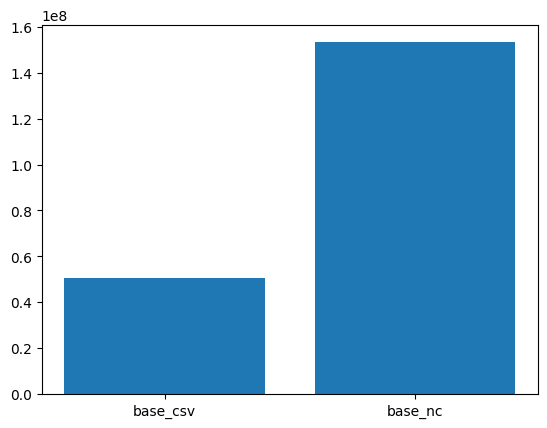

In [211]:
plt.bar(["base_csv", "base_nc"], [de_base_s_nom_sum, de_nc_s_nom_sum])

In [221]:
de_base_network_s_nom.head()

,Unnamed: 0,line_id,tag_type,country,length,voltage,circuits,tag_frequency,bus0,bus1,underground,under_construction,dc,geometry,bounds,bus_0_coors,bus_1_coors,bus0_lon,bus0_lat,bus1_lon,bus1_lat,s_nom
0,0,5028568-1_0,line,DE,3519.222939,110000,2.0,50.0,395,1618,False,False,False,"LINESTRING (6.3746 51.6023, 6.3363875 51.62279...","MULTIPOINT ((6.3746 51.6023), (6.2829 51.6447))",POINT (6.3746 51.6023),POINT (6.2829 51.6447),6.3746,51.6023,6.2829,51.6447,245778.009594
1,1,7954291-1_0,line,DE,12262.610024,110000,2.0,50.0,805,82,False,False,False,"LINESTRING (9.0477 48.9026, 9.047101400000019 ...","MULTIPOINT ((9.0477 48.9026), (9.0824 48.826))",POINT (9.0477 48.9026),POINT (9.0824 48.826),9.0477,48.9026,9.0824,48.8260,245778.009594
2,2,7979022-1_0,line,DE,7420.291581,110000,2.0,50.0,1621,10,False,False,False,"LINESTRING (13.5581 52.5898, 13.5579087 52.589...","MULTIPOINT ((13.5581 52.5898), (13.4955 52.5998))",POINT (13.5581 52.5898),POINT (13.4955 52.5998),13.5581,52.5898,13.4955,52.5998,245778.009594
3,3,8004066-1_0,line,DE,15735.229318,220000,1.0,50.0,1623,3053,False,False,False,"LINESTRING (8.6805 49.9747, 8.679419 49.973864...","MULTIPOINT ((8.6805 49.9747), (8.5807 49.973))",POINT (8.6805 49.9747),POINT (8.5807 49.973),8.6805,49.9747,8.5807,49.9730,491556.019188
4,4,8097821-1_0,line,DE,9659.368352,110000,2.0,50.0,922,3279,False,False,False,"LINESTRING (13.8897 53.3422, 13.8739728 53.341...","MULTIPOINT ((13.8897 53.3422), (13.7783 53.338))",POINT (13.8897 53.3422),POINT (13.7783 53.338),13.8897,53.3422,13.7783,53.3380,245778.009594


In [222]:
de_base_nc.lines.head()

,tag_type,country,length,v_nom,num_parallel,tag_frequency,bus0,bus1,underground,under_construction,dc,geometry,bounds,bus_0_coors,bus_1_coors,bus0_lon,bus0_lat,bus1_lon,bus1_lat,carrier,type,s_max_pu,s_nom,underwater_fraction,x,r,g,b,s_nom_extendable,s_nom_min,s_nom_max,capital_cost,build_year,lifetime,terrain_factor,v_ang_min,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu,x_pu_eff,r_pu_eff,s_nom_opt
Line,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5028568-1_0,line,DE,3.519223,220.0,2.0,50.0,395,1618,False,False,False,"LINESTRING (6.3746 51.6023, 6.3363875 51.62279...","MULTIPOINT ((6.3746 51.6023), (6.2829 51.6447))",POINT (6.3746 51.6023),POINT (6.2829 51.6447),6.3746,51.6023,6.2829,51.6447,AC,Al/St 240/40 2-bundle 220.0,0.7,983.112038,0.0,0.0,0.0,0.0,0.0,False,0.0,inf,0.0,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7954291-1_0,line,DE,12.262610,220.0,2.0,50.0,805,82,False,False,False,"LINESTRING (9.0477 48.9026, 9.047101400000019 ...","MULTIPOINT ((9.0477 48.9026), (9.0824 48.826))",POINT (9.0477 48.9026),POINT (9.0824 48.826),9.0477,48.9026,9.0824,48.8260,AC,Al/St 240/40 2-bundle 220.0,0.7,983.112038,0.0,0.0,0.0,0.0,0.0,False,0.0,inf,0.0,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7979022-1_0,line,DE,7.420292,220.0,2.0,50.0,1621,10,False,False,False,"LINESTRING (13.5581 52.5898, 13.5579087 52.589...","MULTIPOINT ((13.5581 52.5898), (13.4955 52.5998))",POINT (13.5581 52.5898),POINT (13.4955 52.5998),13.5581,52.5898,13.4955,52.5998,AC,Al/St 240/40 2-bundle 220.0,0.7,983.112038,0.0,0.0,0.0,0.0,0.0,False,0.0,inf,0.0,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8004066-1_0,line,DE,15.735229,220.0,1.0,50.0,1623,3053,False,False,False,"LINESTRING (8.6805 49.9747, 8.679419 49.973864...","MULTIPOINT ((8.6805 49.9747), (8.5807 49.973))",POINT (8.6805 49.9747),POINT (8.5807 49.973),8.6805,49.9747,8.5807,49.9730,AC,Al/St 240/40 2-bundle 220.0,0.7,491.556019,0.0,0.0,0.0,0.0,0.0,False,0.0,inf,0.0,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8097821-1_0,line,DE,9.659368,220.0,2.0,50.0,922,3279,False,False,False,"LINESTRING (13.8897 53.3422, 13.8739728 53.341...","MULTIPOINT ((13.8897 53.3422), (13.7783 53.338))",POINT (13.8897 53.3422),POINT (13.7783 53.338),13.8897,53.3422,13.7783,53.3380,AC,Al/St 240/40 2-bundle 220.0,0.7,983.112038,0.0,0.0,0.0,0.0,0.0,False,0.0,inf,0.0,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Length Comparison

In [217]:
de_base_len = de_base_network_s_nom[de_base_network_s_nom.voltage >= 220000].length.sum() / 1000
de_base_len

29737.03489177709

In [218]:
de_nc_len = de_base_nc.lines.length.sum()
de_nc_len

81216.86740594925

<BarContainer object of 2 artists>

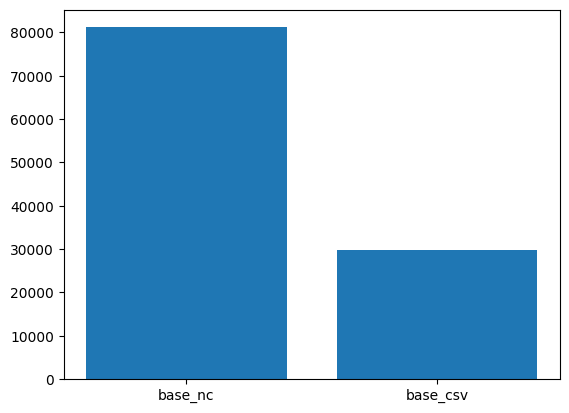

In [219]:
plt.bar(["base_nc", "base_csv"], [de_nc_len, de_base_len])

In [183]:
it_base_len = it_base_network_s_nom[it_base_network_s_nom.voltage >= 220000].length.sum() / 1000
it_base_len

25900.686384993845

In [184]:
it_nc_len = it_base_nc.lines.length.sum()
it_nc_len

76733.79762755937

<BarContainer object of 2 artists>

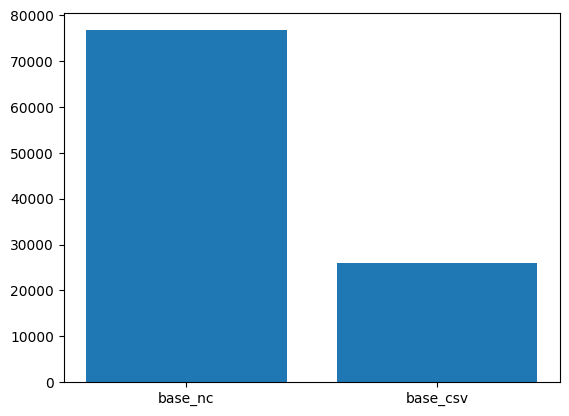

In [213]:
plt.bar(["base_nc", "base_csv"], [it_nc_len, it_base_len])

## close section

In [13]:
base_nc = pypsa.Network("base.nc")
entsoe_elec_nc = pypsa.Network("elec-entsoe.nc")

INFO:pypsa.io:Imported network base.nc has buses, lines, links, transformers
INFO:pypsa.io:Imported network elec-entsoe.nc has buses, carriers, generators, lines, links, loads, storage_units, transformers


In [37]:
at_path = "at_resources"
mk_path = "mk_resources"

# Load clean, raw, and country shapefiles for Austria (AT) with GeoPandas.
at_osm_clean_lines = gpd.read_file(f"{at_path}/osm/clean/all_clean_lines.geojson")
at_osm_raw_lines = gpd.read_file(f"{at_path}/osm/raw/all_raw_lines.geojson")
at_country_shape = gpd.read_file(f"{at_path}/shapes/country_shapes.geojson")

# Load clean, raw, and country shapefiles for North Macedonia (MK) with GeoPandas.
mk_osm_clean_lines = gpd.read_file(f"{mk_path}/osm/clean/all_clean_lines.geojson")
mk_osm_raw_lines = gpd.read_file(f"{mk_path}/osm/raw/all_raw_lines.geojson")
mk_country_shape = gpd.read_file(f"{mk_path}/shapes/country_shapes.geojson")

at_base_network_lines_csv = pd.read_csv(f"{at_path}/base_network/all_lines_build_network.csv")



In [28]:
base_nc

PyPSA Network 'PyPSA-Eur'
Components:
 - Bus: 27031
 - Line: 33449
 - Link: 319
 - Transformer: 5412
Snapshots: 8760

(<matplotlib.collections.PatchCollection at 0x7f3c99edc640>,
 <matplotlib.collections.LineCollection at 0x7f3c69352020>)

/home/gbotemi/miniconda3/envs/pypsa-earth/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning:

facecolor will have no effect as it has been defined as "never".



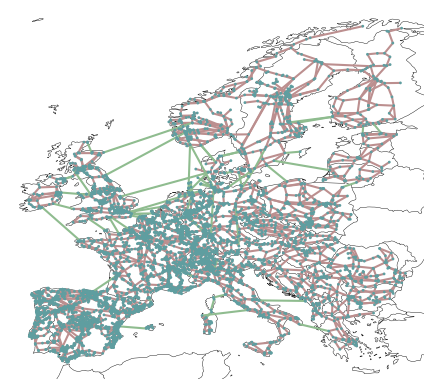

In [29]:
entsoe_elec_nc.plot()

(<matplotlib.collections.PatchCollection at 0x7f3ca0ac6ef0>,
 <matplotlib.collections.LineCollection at 0x7f3c998cb250>)

/home/gbotemi/miniconda3/envs/pypsa-earth/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning:

facecolor will have no effect as it has been defined as "never".



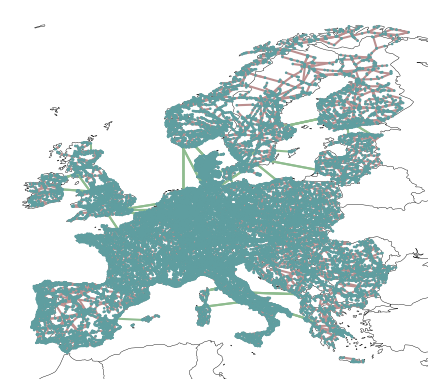

In [7]:
base_nc.plot()

In [26]:
base_nc.lines.columns

Index(['tag_type', 'country', 'length', 'v_nom', 'num_parallel',
       'tag_frequency', 'bus0', 'bus1', 'underground', 'under_construction',
       'dc', 'geometry', 'bounds', 'bus_0_coors', 'bus_1_coors', 'bus0_lon',
       'bus0_lat', 'bus1_lon', 'bus1_lat', 'carrier', 'type', 's_max_pu',
       's_nom', 'underwater_fraction', 'x', 'r', 'g', 'b', 's_nom_extendable',
       's_nom_min', 's_nom_max', 'capital_cost', 'build_year', 'lifetime',
       'terrain_factor', 'v_ang_min', 'v_ang_max', 'sub_network', 'x_pu',
       'r_pu', 'g_pu', 'b_pu', 'x_pu_eff', 'r_pu_eff', 's_nom_opt'],
      dtype='object')

In [22]:
base_nc.lines['type'].value_counts()

Al/St 240/40 2-bundle 220.0    29271
Al/St 240/40 4-bundle 380.0     3604
Al/St 240/40 3-bundle 300.0      574
Name: type, dtype: int64

In [23]:
entsoe_elec_nc.lines['type'].value_counts()

Al/St 240/40 2-bundle 220.0    3407
Al/St 240/40 4-bundle 380.0    2888
Al/St 240/40 3-bundle 300.0     397
Name: type, dtype: int64

In [24]:
entsoe_elec_nc.line_types

,f_nom,r_per_length,x_per_length,c_per_length,i_nom,mounting,cross_section,references
LineType,,,,,,,,
149-AL1/24-ST1A 10.0,50.0,0.19400,0.315000,11.25,0.470,ol,149.0,pandapower;Heuck et al. Elektrische Energiever...
149-AL1/24-ST1A 110.0,50.0,0.19400,0.410000,8.75,0.470,ol,149.0,pandapower;Heuck et al. Elektrische Energiever...
149-AL1/24-ST1A 20.0,50.0,0.19400,0.337000,10.50,0.470,ol,149.0,pandapower;Heuck et al. Elektrische Energiever...
15-AL1/3-ST1A 0.4,50.0,1.87690,0.350000,11.00,0.105,ol,16.0,pandapower;Heuck et al. Elektrische Energiever...
184-AL1/30-ST1A 110.0,50.0,0.15710,0.400000,8.80,0.535,ol,184.0,pandapower;Heuck et al. Elektrische Energiever...
184-AL1/30-ST1A 20.0,50.0,0.15710,0.330000,10.75,0.535,ol,184.0,pandapower;Heuck et al. Elektrische Energiever...
24-AL1/4-ST1A 0.4,50.0,1.20120,0.335000,11.25,0.140,ol,24.0,pandapower;Heuck et al. Elektrische Energiever...
243-AL1/39-ST1A 110.0,50.0,0.11880,0.390000,9.00,0.645,ol,243.0,pandapower;Heuck et al. Elektrische Energiever...
243-AL1/39-ST1A 20.0,50.0,0.11880,0.320000,11.00,0.645,ol,243.0,pandapower;Heuck et al. Elektrische Energiever...


In [35]:
at_osm_clean_lines.head()

,line_id,tag_type,country,length,voltage,circuits,tag_frequency,bus0,bus1,underground,under_construction,dc,geometry
0,23049236-1,line,AT,7216.784231,400000,2.0,50.0,NaN,NaN,False,False,False,"LINESTRING (16.42058 48.33712, 16.41992 48.335..."
1,24769198-1,line,AT,2661.609512,110000,4.0,50.0,NaN,NaN,False,False,False,"LINESTRING (11.47093 47.27259, 11.46907 47.272..."
2,24786714-1,line,AT,1463.605791,110000,2.0,50.0,NaN,NaN,False,False,False,"LINESTRING (14.34722 48.26713, 14.34701 48.266..."
3,24786841-1,line,AT,1554.967471,110000,2.0,50.0,NaN,NaN,False,False,False,"LINESTRING (14.32526 48.32387, 14.32807 48.323..."
4,25359793-1,line,AT,47488.422697,220000,2.0,50.0,NaN,NaN,False,False,False,"LINESTRING (11.47170 47.27237, 11.47214 47.271..."


In [38]:
at_base_network_lines_csv.head()

,Unnamed: 0,line_id,tag_type,country,length,voltage,circuits,tag_frequency,bus0,bus1,underground,under_construction,dc,geometry,bounds,bus_0_coors,bus_1_coors,bus0_lon,bus0_lat,bus1_lon,bus1_lat
0,0,23049236-1_0,line,AT,7216.784231,400000,2.0,50.0,9,487,False,False,False,"LINESTRING (16.384 48.3589, 16.42057520000003 ...","MULTIPOINT (16.384 48.3589, 16.3959 48.2972)",POINT (16.384 48.3589),POINT (16.3959 48.2972),16.3840,48.3589,16.3959,48.2972
1,1,25359793-1_0,line,AT,12585.693857,220000,2.0,50.0,11,207,False,False,False,"LINESTRING (11.4758 47.2731, 11.47169570000002...","MULTIPOINT (11.4758 47.2731, 11.3946 47.2401)",POINT (11.4758 47.2731),POINT (11.3946 47.2401),11.4758,47.2731,11.3946,47.2401
2,2,25359793-1_1,line,AT,34902.728840,220000,2.0,50.0,207,274,False,False,False,"LINESTRING (11.3946 47.2401, 11.3917933 47.237...","MULTIPOINT (11.3946 47.2401, 11.1053 47.2941)",POINT (11.3946 47.2401),POINT (11.1053 47.2941),11.3946,47.2401,11.1053,47.2941
3,3,25359794-1_0,line,AT,152341.236268,220000,2.0,50.0,167,203,False,False,False,"LINESTRING (10.8736 47.2449, 10.87686169999994...","MULTIPOINT (10.8736 47.2449, 11.8986 47.2349)",POINT (10.8736 47.2449),POINT (11.8986 47.2349),10.8736,47.2449,11.8986,47.2349
4,4,25528575-1_0,line,AT,25513.577325,220000,2.0,50.0,7,50,False,False,False,"LINESTRING (16.382 48.3569, 16.377387 48.35623...","MULTIPOINT (16.382 48.3569, 16.2407 48.3569)",POINT (16.382 48.3569),POINT (16.2407 48.3569),16.3820,48.3569,16.2407,48.3569


In [41]:
at_base_network_lines_csv.columns

Index(['Unnamed: 0', 'line_id', 'tag_type', 'country', 'length', 'voltage',
       'circuits', 'tag_frequency', 'bus0', 'bus1', 'underground',
       'under_construction', 'dc', 'geometry', 'bounds', 'bus_0_coors',
       'bus_1_coors', 'bus0_lon', 'bus0_lat', 'bus1_lon', 'bus1_lat'],
      dtype='object')

In [43]:
def get_i_nom_by_voltage(voltage_value: int) -> int:

    voltage_dict = {
        "220" : 1.29, # "Al/St 240/40 2-bundle 220.0"
        "300" : 1.935, # "Al/St 240/40 3-bundle 300.0,"
        "380" : 2.58 # "Al/St 240/40 4-bundle 380.0"
    }

    if voltage_value <= 220000:
        current = voltage_dict["220"]
    elif voltage_value > 220000 and voltage_value <= 300000:
        current = voltage_dict["300"]
    elif voltage_value > 300000:
        current = voltage_dict["380"]

    return current

In [46]:
get_i_nom_by_voltage(300000)

1.935

In [49]:
math.sqrt(3)

1.7320508075688772

In [50]:
at_base_network_lines_csv["s_nom"] = at_base_network_lines_csv["voltage"].apply(lambda row: row * math.sqrt(3) * get_i_nom_by_voltage(row))

In [57]:
(at_base_network_lines_csv["s_nom"] * at_base_network_lines_csv["length"]).sum()

6495896328550.507